# Transfer Learning with PyTorch using Azure Machine Learning

In [21]:
import os, random
import azureml
import shutil
import urllib.request
from pathlib import Path
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import cv2
import urllib3 
import zipfile

from azureml.core.model import Model, InferenceConfig
from azureml.core import Workspace, Datastore, Experiment, Run
from azureml.core.compute import ComputeTarget, AmlCompute, AksCompute, ComputeTarget
from azureml.train.dnn import PyTorch
from azureml.widgets import RunDetails

from azureml.core.webservice import Webservice, AksWebservice, AciWebservice
from azureml.core.environment import Environment

from azureml.core.dataset import Dataset
from azureml.core.resource_configuration import ResourceConfiguration
from azureml.core.conda_dependencies import CondaDependencies 

# check core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.7.0


## 1 - Connect to the AML Workspace Environment

In [22]:
# Connect to workspace
ws = Workspace.from_config()
print("Workspace:",ws.name)

# Connect to compute for training
compute_target = ComputeTarget(workspace=ws, name="OptimusPrime")
print("Compute Target:",compute_target.name)

# Connect to the datastore for the training images
ds = Datastore.get_default(ws)
print("Datastore:",ds.name)

# Connect to the experiment
exp = Experiment(workspace=ws, name='Simpsons-PyTorch')
print("Experiment:",exp.name)

Workspace: Cybertron
Compute Target: OptimusPrime
Datastore: workspaceblobstore
Experiment: Simpsons-PyTorch


## 2 - Data

### 2.1 Download and extract the data

In [ ]:
# Download the dataset from Github
data_url = "https://github.com/hnky/dataset-lego-figures/raw/master/_download/train-and-validate.zip"
data_path = "./data"
download_path = os.path.join(data_path,"train-and-validate.zip")
if not os.path.exists(data_path):
    os.mkdir(data_path,);
urllib.request.urlretrieve(data_url, filename=download_path)

In [ ]:
# Unzip the dataset
zip_ref = zipfile.ZipFile(download_path, 'r')
zip_ref.extractall(data_path)
zip_ref.close()
print("Data extracted in: {}".format(data_path))

os.remove(download_path)
print("Downloaded file removed: {}".format(download_path))

### 2.2 Upload the data to AML datastore

In [ ]:
# Upload all the data to the datastore
ds.upload(src_dir=data_path, target_path='simpsonslego-v3', overwrite=True, show_progress=True)

### 2.3 Create a Dataset from the images

In [ ]:
# create a FileDataset pointing to files in 'simpsons' folder and its subfolders recursively
datastore_paths = [(ds, 'simpsonslego-v3/**')]
simpsons_ds = Dataset.File.from_files(path=datastore_paths)

In [ ]:
# Register the dataset in AMLS
simpsons_ds.register(workspace=ws,
             name='LegoSimpsons-v3',
             description='Simpsons dataset with Lego Figures',
             create_new_version = True)

In [23]:
# Or connect to previous version of the data
simpsons_ds = Dataset.get_by_name(ws, name='LegoSimpsons-v3')

### 2.4 Preview the dataset

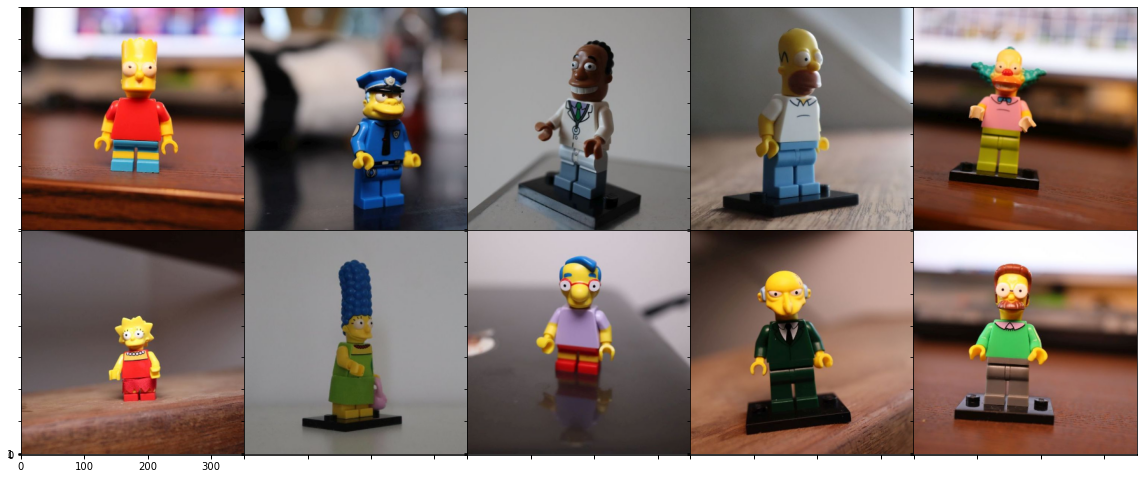

In [24]:
path = r"data/train"
random_filenames = []
for tag in os.listdir(path):
    random_filenames.append(path+"/"+tag+"/"+random.choice([
        x for x in os.listdir(os.path.join(path,tag))
        if os.path.isfile(os.path.join(path,tag, x))
    ]))

grid = AxesGrid(plt.figure(1, (20,20)), 111, nrows_ncols=(4, 5), axes_pad=0, label_mode="1")

i = 0
for img_name in random_filenames[0:10]:
    
    # Download image
    image = cv2.imread(img_name)
    image = cv2.resize(image, (352, 352))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Show image in grid
    grid[i].imshow(image)
    i = i+1

## 3 - Train the model

### 3.1 Create a training script

In [25]:
%%writefile 'trainingscripts/train.py'

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import time
import os
import copy

### Add References
import argparse
from azureml.core import Run

### Add run context for AML
run = Run.get_context()

### Parse incoming parameters
parser = argparse.ArgumentParser()
parser.add_argument("--data-folder", type=str, dest="data_folder", help="data folder mounting point", default="")
parser.add_argument("--num-epochs", type=int, dest="num_epochs", help="Number of epochs", default="")

args = parser.parse_args()
data_path = args.data_folder
num_epochs = args.num_epochs

### Prepare the dataset
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_path, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
            
            print(phase,running_loss,dataset_sizes[phase])
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            # Log the los / acc to AMLS
            run.log("{} Loss".format(phase), np.float(epoch_loss))
            run.log("{} Acc".format(phase), np.float(epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=num_epochs)

# Save the model
torch.save(model_ft, './outputs/model.pth')

# Save the labels
with open('./outputs/labels.txt', 'w') as f:
    f.writelines(["%s\n" % item  for item in class_names])

Overwriting trainingscripts/train.py


### 3.2 Create and run a PyTorch Estimator

In [26]:
# Create the PyTorch estimator
script_params = {
    '--data-folder': simpsons_ds.as_named_input('simpsonsdataset').as_mount(),
    '--num-epochs': 15
}

# The folder that contains your training script.
# This contents folder is being versioned in the experiment.
project_folder = "./trainingscripts"

estimator = PyTorch(source_directory=project_folder, 
                    script_params=script_params,
                    compute_target=compute_target,
                    entry_script='train.py',
                    use_gpu=True,
                    pip_packages=['azureml-dataprep[fuse,pandas]','pillow==5.4.1'],
                    framework_version='1.3')

In [27]:
# Run the PyTorch estimator
run = exp.submit(estimator)

In [28]:
# Show the PyTorch estimator
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

In [ ]:
# Handy functions
print(run.status)
#run.cancel()

In [ ]:
# Load a historic run
previousRunId = 'Simpsons-PyTorch_1597837140_e9b86c10'
run = [r for r in exp.get_runs() if r.id == previousRunId][0]
RunDetails(run).show()

### 3.3 Register the model in Azure ML

In [29]:
model = run.register_model(model_name='Simpsons-PyTorch',
                           model_path='outputs',
                           model_framework='PyTorch',
                           model_framework_version='1.3',
                           description="Simpsons PyTorch Classifier (From Jupyter Notebook)",
                           tags={'Conference':'Code PaLOUsa'},
                           resource_configuration=ResourceConfiguration(cpu=1, memory_in_gb=2))

print("Model '{}' version {} registered ".format(model.name,model.version))

Model 'Simpsons-PyTorch' version 33 registered 


### 3.4 Download & Test the model

In [30]:
model.download(exist_ok=True)

'outputs'

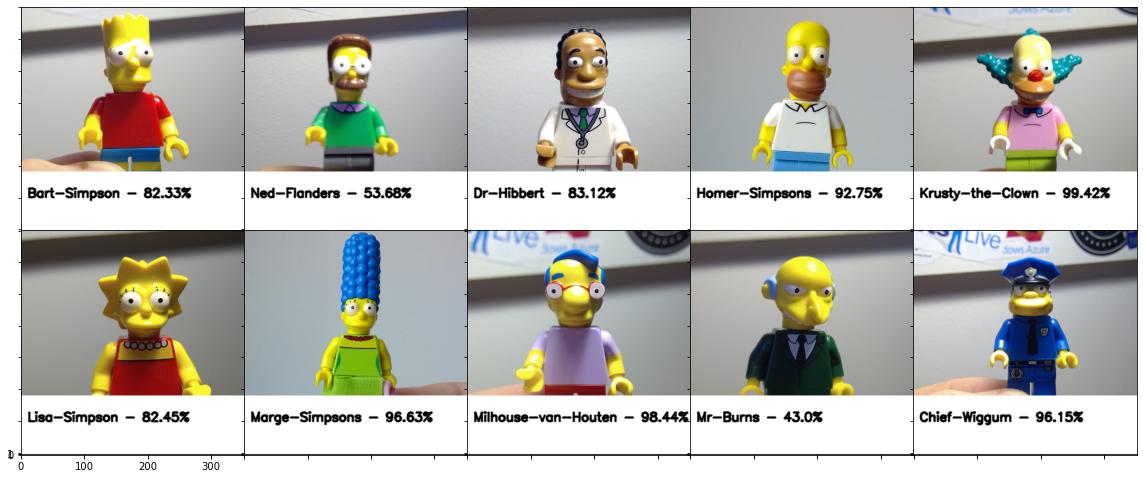

In [31]:
import os
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import json
import urllib
from PIL import Image

# Load the model
loaded_model = torch.load(os.path.join('outputs','model.pth'), map_location=lambda storage, loc: storage)
loaded_model.eval()

# Load the labels
with open(os.path.join('outputs','labels.txt'), 'rt') as lf:
    global labels
    labels = [l.strip() for l in lf.readlines()]

    
def scoreImage(image_link):
    # Load the image to predict
    input_image = Image.open(image_link)

    # Pre process
    preprocess = transforms.Compose([
        transforms.Resize(225),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0)

    # Predict the image
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        loaded_model.to('cuda')

    with torch.no_grad():
        output = loaded_model(input_batch)

    index = output.data.cpu().numpy().argmax()
    probability = torch.nn.functional.softmax(output[0], dim=0).data.cpu().numpy().max()

    #Return the result
    return {"label": labels[index], "probability": round(probability*100,2)}



path = r"data/test"
grid = AxesGrid(plt.figure(1, (20,20)), 111, nrows_ncols=(4, 5), axes_pad=0, label_mode="1")

i = 0
for img in os.listdir(path):
    
    #Score the image
    result = scoreImage(os.path.join(path,img))
    
    # Download image
    image = cv2.imread(os.path.join(path,img))
    image = cv2.resize(image, (352, 352))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    cv2.rectangle(image, (0,260),(352,352),(255,255,255), -1)
    cv2.putText(image, "{} - {}%".format(result['label'],result['probability']),(10, 300), cv2.FONT_HERSHEY_SIMPLEX, 0.65,(0,0,0),2,cv2.LINE_AA)    
    
    # Show image in grid
    grid[i].imshow(image)
    i = i+1

## 4 Deploy the model

### 4.1 Create a scoring script

In [32]:
%%writefile 'score.py'
import os
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import json
import urllib
from PIL import Image

from azureml.core.model import Model

def init():
    global model
    model_path = os.path.join(os.getenv('AZUREML_MODEL_DIR'), 'outputs','model.pth')
    labels_path = os.path.join(os.getenv('AZUREML_MODEL_DIR'), 'outputs','labels.txt')
    
    print('Loading model...', end='')
    model = torch.load(model_path, map_location=lambda storage, loc: storage)
    model.eval()
    
    print('Loading labels...', end='')
    with open(labels_path, 'rt') as lf:
        global labels
        labels = [l.strip() for l in lf.readlines()]
    print(len(labels), 'found. Success!')

    
def run(input_data):
    url = json.loads(input_data)['url']
    urllib.request.urlretrieve(url, filename="tmp.jpg")
    
    input_image = Image.open("tmp.jpg")

    preprocess = transforms.Compose([
        transforms.Resize(225),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

    # move the input and model to GPU for speed if available
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')

    with torch.no_grad():
        output = model(input_batch)

    index = output.data.cpu().numpy().argmax()
    probability = torch.nn.functional.softmax(output[0], dim=0).data.cpu().numpy().max()

    result = {"label": labels[index], "probability": round(probability*100,2)}
    os.remove("tmp.jpg")
    return result

Overwriting score.py


### 4.2 Create an environment file

In [ ]:
myenv = CondaDependencies.create(pip_packages=['azureml-defaults ', 'torch', 'torchvision','pillow==5.4.1'])

with open("myenv.yml","w") as f:
    f.write(myenv.serialize_to_string())
    
myenv = Environment.from_conda_specification(name="myenv", file_path="myenv.yml")

### 4.3 Create an Inference config

In [ ]:
inference_config = InferenceConfig(entry_script="score.py", environment=myenv)

### 4.4 Deploy to ACI

In [ ]:
model = Model(ws, name='Simpsons-PyTorch')
print("Loaded model version:",model.version)

In [ ]:
# Create a deployment config
deploy_config = AciWebservice.deploy_configuration(
                    cpu_cores = model.resource_configuration.cpu, 
                    memory_gb = model.resource_configuration.memory_in_gb,
                    description='Simpson Lego Classifier')

In [ ]:
# Deploy the model to an ACI
aci_service = Model.deploy(ws, 
                name="simpsons-pt-aci", 
                models = [model], 
                inference_config = inference_config, 
                deployment_config = deploy_config, 
                overwrite = True)

aci_service.wait_for_deployment(show_output=True)

In [ ]:
# Connect to previous deployment
aci_service = AciWebservice(ws, "simpsons-pt-aci")

In [33]:
print("Scoring endpoint:",aci_service.scoring_uri)

Scoring endpoint: http://f401ce93-9bc7-468c-8d0d-7566e6a1f0ec.westeurope.azurecontainer.io/score


### 4.4 Deploy to Azure Kuberneter Service

In [ ]:
aks_target = AksCompute(ws,"AKS-Demo-v2")

deployment_config = AksWebservice.deploy_configuration(
    cpu_cores = 1, 
    memory_gb = 2)

aks_service = Model.deploy(workspace=ws, 
                       name="simpsons-pytorch-2", 
                       models=[model], 
                       inference_config=inference_config, 
                       deployment_config=deployment_config, 
                       deployment_target=aks_target,
                       overwrite=True)

aks_service.wait_for_deployment(show_output = True)

In [ ]:
### Connect to a previous deployed service
aks_service = [r for r in AksWebservice.list(ws) if r.name == 'simpsons-pytorch'][0]

In [ ]:
print(aks_service.scoring_uri)
aks_service.get_keys()

### 4.4 Test the API

In [ ]:
%%writefile 'test-images-urls.txt'
https://raw.githubusercontent.com/hnky/dataset-lego-figures/master/_test/Krusty.jpg
https://raw.githubusercontent.com/hnky/dataset-lego-figures/master/_test/Bart.jpg
https://raw.githubusercontent.com/hnky/dataset-lego-figures/master/_test/Flanders.jpg
https://raw.githubusercontent.com/hnky/dataset-lego-figures/master/_test/Homer.jpg
https://raw.githubusercontent.com/hnky/dataset-lego-figures/master/_test/Lisa.jpg
https://raw.githubusercontent.com/hnky/dataset-lego-figures/master/_test/marge.jpg
https://raw.githubusercontent.com/hnky/dataset-lego-figures/master/_test/Milhouse.jpg
https://raw.githubusercontent.com/hnky/dataset-lego-figures/master/_test/MrBurns.jpg
https://raw.githubusercontent.com/hnky/dataset-lego-figures/master/_test/Wiggum.jpg

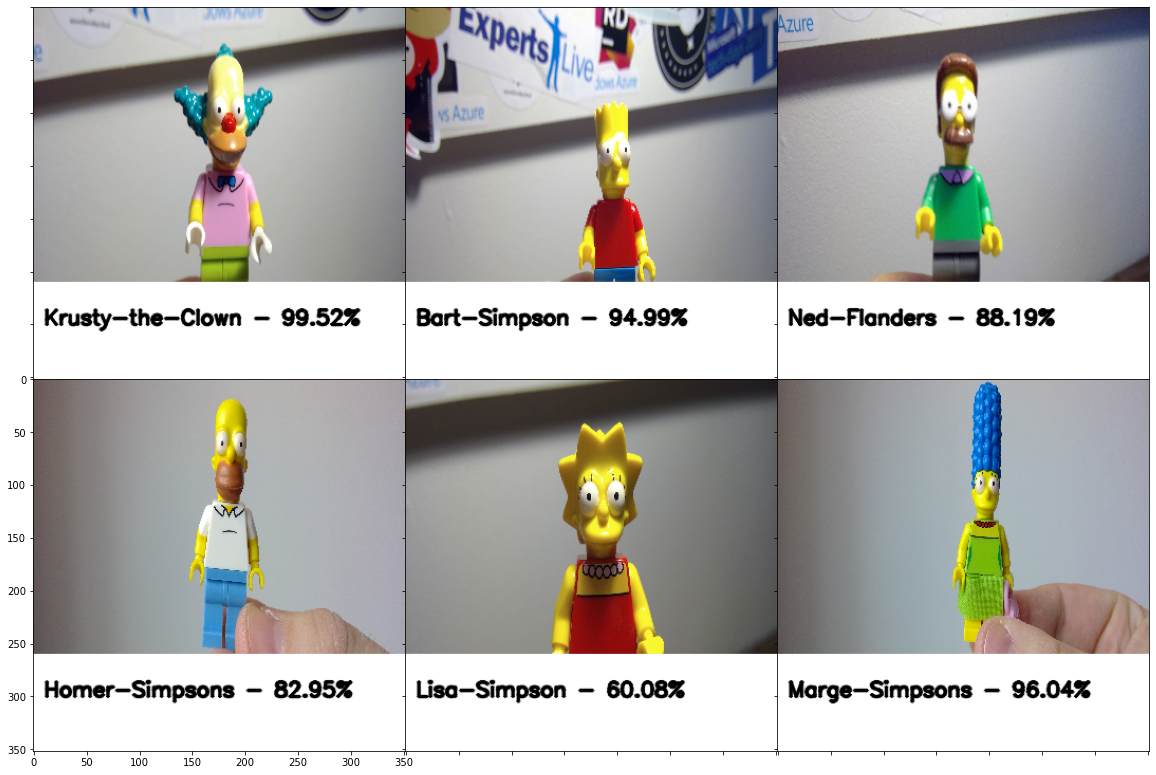

In [34]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
from PIL import Image as ImagePil
import requests
from io import BytesIO
import cv2
import urllib
import cv2
import numpy as np
import json

F = plt.figure(1, (20,20))
grid = AxesGrid(F, 111, nrows_ncols=(2, 3), axes_pad=0, label_mode="1")

with open('test-images-urls.txt', 'rt') as lf:
    global testimages
    testimages = [l.strip() for l in lf.readlines()]
    
def url_to_image(url):
    with urllib.request.urlopen(url) as url:
        s = url.read()
    image = np.asarray(bytearray(s), dtype="uint8")
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (352, 352))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image


i = 0
for img_name in testimages[0:6]:
    
    # Predict Url ACI
    result = aci_service.run(input_data=json.dumps({ "url": img_name}))
    
    # Predict Url AKS
    #result = aks_service.run(input_data=json.dumps({ "url": img_name}))

    # Download image
    img = url_to_image(img_name)
 
    # Draw result on image
    cv2.rectangle(img, (0,260),(352,352),(255,255,255), -1)
    cv2.putText(img, "{} - {}%".format(result['label'],result['probability']),(10, 300), cv2.FONT_HERSHEY_SIMPLEX, 0.65,(0,0,0),2,cv2.LINE_AA)

    # Show image in grid
    grid[i].imshow(img)
    i = i+1

In [ ]:
with open('test-images-urls.txt', 'rt') as lf:
    global testimages
    testimages = [l.strip() for l in lf.readlines()]

print(testimages)